# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [75]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.datasets import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data (CIFAR-100 with 20 superclasses)

In this homework, we will be classifying images from the CIFAR-100 dataset into the 20 superclasses. More information about the CIFAR-100 dataset and the 20 superclasses can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

Download the CIFAR-100 data files [here](https://drive.google.com/drive/folders/1imXxTnpkMbWEe41pkAGNt_JMTXECDSaW?usp=share_link), and save the `.mat` files to the `data/cifar100` directory.

In [76]:
data = CIFAR100_data('data/cifar100/')
for k, v in data.items():
    if type(v) == np.ndarray:
        print ("Name: {} Shape: {}, {}".format(k, v.shape, type(v)))
    else:
        print("{}: {}".format(k, v))
label_names = data['label_names']
mean_image = data['mean_image'][0]
std_image = data['std_image'][0]

Name: data_train Shape: (40000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_train Shape: (40000,), <class 'numpy.ndarray'>
Name: data_val Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_val Shape: (10000,), <class 'numpy.ndarray'>
Name: data_test Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_test Shape: (10000,), <class 'numpy.ndarray'>
label_names: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Name: mean_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>
Name: std_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>


Label: large_omnivores_and_herbivores


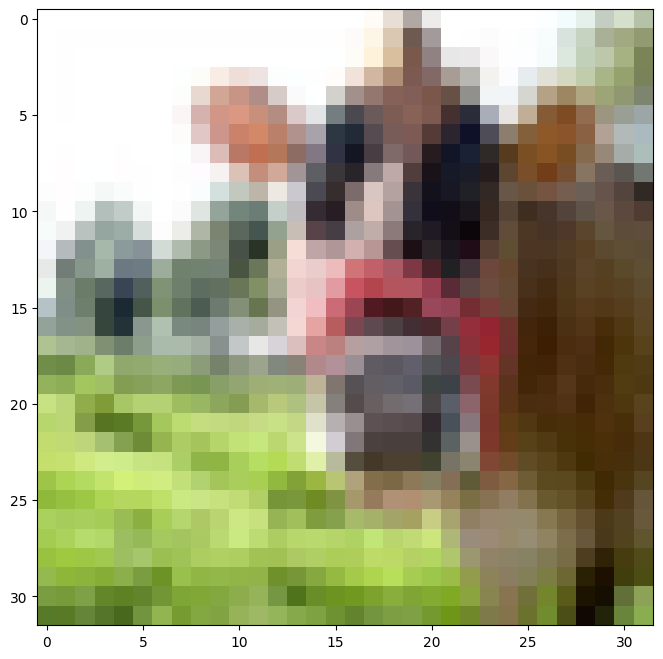

In [77]:
idx = 0
image_data = data['data_train'][idx]
image_data = ((image_data*std_image + mean_image) * 255).astype(np.int32)
plt.imshow(image_data)
label = label_names[data['labels_train'][idx]]
print("Label:", label)

## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [78]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received [32, 16, 16, 16] and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [79]:
%reload_ext autoreload

# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

out = single_conv.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [80]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)

single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)

dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]

# The error should be around 1e-6
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  2.2546755753264287e-08
dw Error:  5.175798553508641e-09
db Error:  4.665698593012792e-11
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [81]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [86]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.276186843072994e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Convolutional Neural Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [9]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("conv1_w").std() - std)
b1 = model.net.get_params("conv1_b").std()
w2_std = abs(model.net.get_params("fc1_w").std() - std)
b2 = model.net.get_params("fc1_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("conv1_w", w1)
model.net.assign("conv1_b", b1)
model.net.assign("fc1_w", w2)
model.net.assign("fc1_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
conv1_b relative error: 1.01e-09
conv1_w relative error: 1.05e-09
fc1_b relative error: 3.65e-10
fc1_w relative error: 3.95e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented (such as fully-connected layers and non-linearities).
You are also free to select any optimizer you have implemented (with any learning rate).

You will train your network on CIFAR-100 20-way superclass classification.
Try to find a combination that is able to achieve 40% validation accuracy.

Since the CNN takes significantly longer to train than the fully connected network, it is suggested to start off with fewer filters in your Conv layers and fewer intermediate fully-connected layers so as to get faster initial results.

In [10]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [11]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (40000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 20


In [29]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
# You may only adjust the hyperparameters within this block                 #
#############################################################################
optimizer = Adam(model.net, 1e-3)

batch_size = 10
epochs = 5
lr_decay = .999
lr_decay_every = 10
regularization = "none"
reg_lambda = 0.01
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=4000, verbose=True, regularization=regularization, reg_lambda=reg_lambda)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

  0%|          | 1/4000 [00:01<1:55:47,  1.74s/it]

(Iteration 1 / 20000) Average loss: 3.001034925522668


100%|██████████| 4000/4000 [2:04:13<00:00,  1.86s/it]  


(Epoch 1 / 5) Training Accuracy: 0.36765, Validation Accuracy: 0.3423


  0%|          | 1/4000 [00:01<2:00:46,  1.81s/it]

(Iteration 4001 / 20000) Average loss: 2.3154061446075054


100%|██████████| 4000/4000 [2:13:58<00:00,  2.01s/it]  


(Epoch 2 / 5) Training Accuracy: 0.422725, Validation Accuracy: 0.3765


  0%|          | 1/4000 [00:01<1:56:45,  1.75s/it]

(Iteration 8001 / 20000) Average loss: 1.9999308835295233


100%|██████████| 4000/4000 [1:50:08<00:00,  1.65s/it]


(Epoch 3 / 5) Training Accuracy: 0.471775, Validation Accuracy: 0.4034


  0%|          | 1/4000 [00:01<1:44:44,  1.57s/it]

(Iteration 12001 / 20000) Average loss: 1.867676979601489


100%|██████████| 4000/4000 [1:44:30<00:00,  1.57s/it]


(Epoch 4 / 5) Training Accuracy: 0.47985, Validation Accuracy: 0.391


  0%|          | 1/4000 [00:01<1:47:02,  1.61s/it]

(Iteration 16001 / 20000) Average loss: 1.769121363689662


100%|██████████| 4000/4000 [1:49:07<00:00,  1.64s/it]


(Epoch 5 / 5) Training Accuracy: 0.522925, Validation Accuracy: 0.415


In [ ]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
# You may only adjust the hyperparameters within this block                 #
#############################################################################
optimizer = Adam(model.net, 1e-3)

batch_size = 10
epochs = 5
lr_decay = .999
lr_decay_every = 10
regularization = "none"
reg_lambda = 0.01
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=4000, verbose=True, regularization=regularization, reg_lambda=reg_lambda)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

Run the code below to generate the training plots.

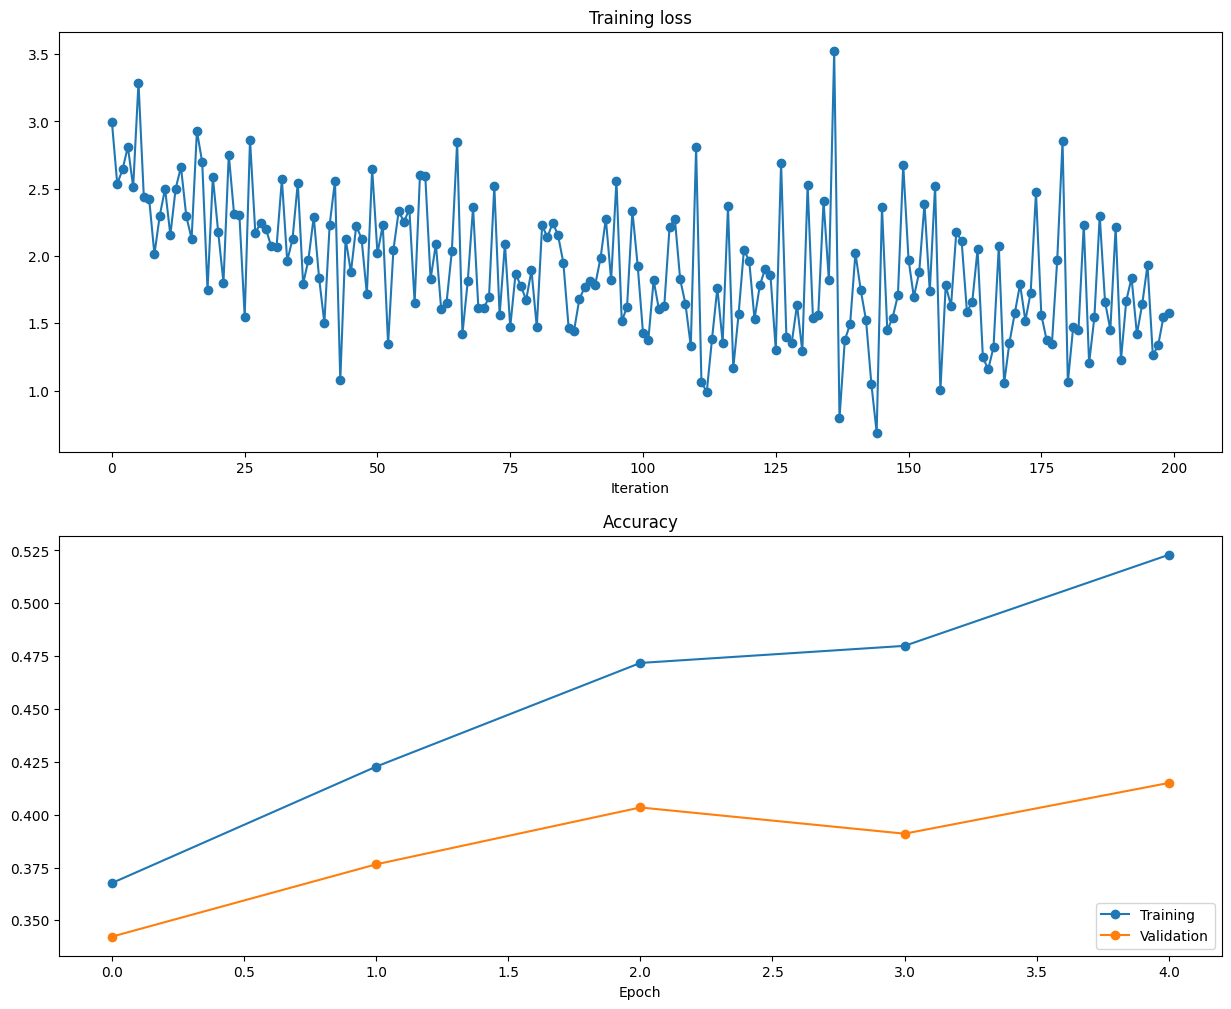

In [31]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

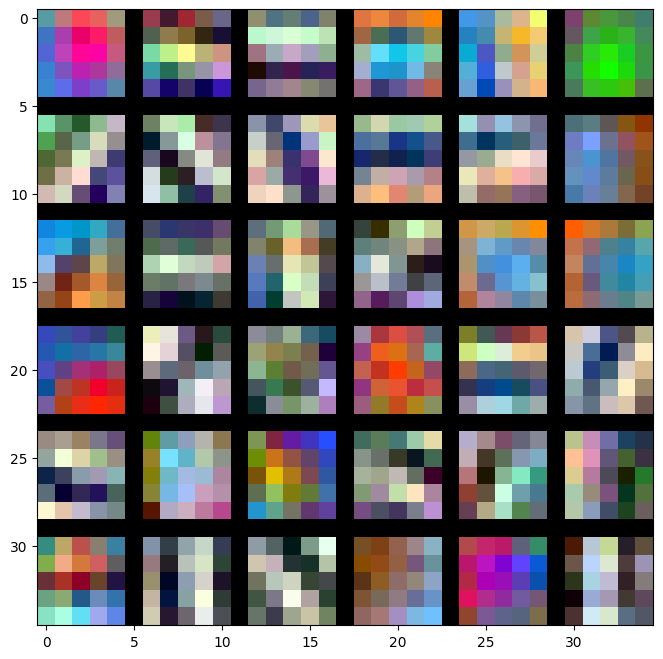

In [153]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
from math import sqrt, ceil

wt_conv1 = model.net.get_params("conv1_w").transpose(3,0, 1, 2)
P =1
 
N, H, W, C = wt_conv1.shape
grid_size = int(ceil(sqrt(N)))
grid_height = H * grid_size + P * (grid_size - 1)
grid_width = W * grid_size + P * (grid_size - 1)
grid = np.zeros((grid_height, grid_width, C))

ni = 0
y0, y1 = 0, H
for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
        if ni < N:
            img = wt_conv1[ni]
            low, high = np.min(img), np.max(img)
            grid[y0:y1, x0:x1] = 255 * (img - low) / (high - low)
            ni += 1
        x0 += W + P
        x1 += W + P
    y0 += H + P
    y1 += H + P

im_array = grid.astype(np.int32)
###################################################
#                END OF YOUR CODE                 #
###################################################

plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

The first layer of the model is defined as follows :
- (C) input_channels = 3
- (K) kernel_size = 5
- (N) number_filters=36
- (S) stride=2
- (P) padding=1
- Input image size = (32,32,3) => (input_height, input_width, channels)
- filter size = (5,5,3,36) => (K,K,C,N)

The above visualization depicts :
- 6x6 grid representing 36 filter
- Each small grid i.e. 5 x 5 map represents a color (r,g,b) matrix applied to the input image. 
- One square represents

Analyses of the above visualization :
- We can see that in some cases, the filter is the similar across the channels (the first row), and in others, the filters differ (the last row)
- The darker squares indicate smaller weights and the lighter squares represent larger weights. 
- We can notice the top left denotes color filter RED (r,g,b) = (0-255,0,0), top right GREEN (r,g,b) = (0,0-255,0) and similarly BLUE.
- Hence, the filters on the first row detect a gradient from redder shades in the top left to dark blacker in the bottom right.

## Extra-Credit: Analysis on Trained Model [5pts]

For extra credit, you can perform some additional analysis of your trained model. Some suggested analyses are:
1. Plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of your model's predictions on the test set. Look for trends to see which classes are frequently misclassified as other classes (e.g. are the two vehicle superclasses frequently confused with each other?).
2. Implement [BatchNorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) and analyze how the models train with and without BatchNorm.
3. Introduce some small noise in the labels, and investigate how that affects training and validation accuracy.

You are free to choose any analysis question of interest to you. We will not be providing any starter code for the extra credit. Include your extra-credit analysis as the final section of your report pdf, titled "Extra Credit".

### EXTRA CREDIT Inline Answer:

- Plotted the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of model's predictions on the test set.
- Justified different trends to see which classes are frequently misclassified as other classes (e.g. are the two vehicle superclasses frequently confused with each other?)
    - We can see in the below graph x-axis denotes expected classes and y denotes predicted classes.
    - Square which are darker are the ones that hold more classification weight for that particular (row-col) predicted-expected mapping. In ideal case along the diagonal the values would be the darkest meaning correct classifications.
    - We mark the trend where there are darker blocks in the heat map of confusion matrix, accounting for misclassifications. Examples of misclassification trends are as follows : 
        - 2, 18 i.e trees and flower (Because of the possible colow matrix being similar)
        - Similarly 18,19 classes i.e. vehicle_1 and vehicle_2 are often mixed and misclassified by the model, possibly because of object similarity
        - Similarly large_natural_outdoor_scenes and aquatic mammals are misclassified, possibly because of close color patterns and arrangements (Attached example after confusion matrix)
        

- Also plotted a pair plot between samples to check for any correlation between them.


In [379]:
def calc_conf_matrix (model, data, labels, num_samples=None, batch_size=1000):
    N = data.shape[0]
    if num_samples is not None and N > num_samples:
        indices = np.random.choice(N, num_samples)
        N = num_samples
        data = data[indices]
        labels = labels[indices]

    num_batches = N // batch_size
    if N % batch_size != 0:
        num_batches += 1
    preds = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        output = model.forward(data[start:end], False)
        scores = softmax(output)
        pred = np.argmax(scores, axis=1)
        preds.append(pred)
        print('Batch ',(i),' processed')
    preds = np.hstack(preds)
    accuracy = np.mean(preds == labels)
    return accuracy, preds

test_data = data['data_test']
test_labels = data['labels_test']
model = SmallConvolutionalNetwork()
model.net.load(opt_params)
test_acc, preds = calc_conf_matrix(model, test_data, test_labels)

Loading Params: conv1_w Shape: (5, 5, 3, 36)
Loading Params: conv1_b Shape: (1, 1, 1, 36)
Loading Params: fc1_w Shape: (1764, 48)
Loading Params: fc1_b Shape: (48,)
Loading Params: fc2_w Shape: (48, 20)
Loading Params: fc2_b Shape: (20,)
Batch  0  processed
Batch  1  processed
Batch  2  processed
Batch  3  processed
Batch  4  processed
Batch  5  processed
Batch  6  processed
Batch  7  processed
Batch  8  processed
Batch  9  processed


Total Test Labels :  10000
Total True predictions :  509
Total False predictions :  9491
Testing accuracy :  5.09

Confusion Matrix Values are as follows : 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [186 245 161 244 198 251 241 180 206 215 234 200 179 201 205 182 216 302
  182 242]
 [ 95  67  89 104  82  79  48 120 107  33  38  80 140 108 100  95  73  26
   75  68]
 [ 20  13   0  13   6  12  19   2   7  17  42   7  16   6   6   7  16  29
   10   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   

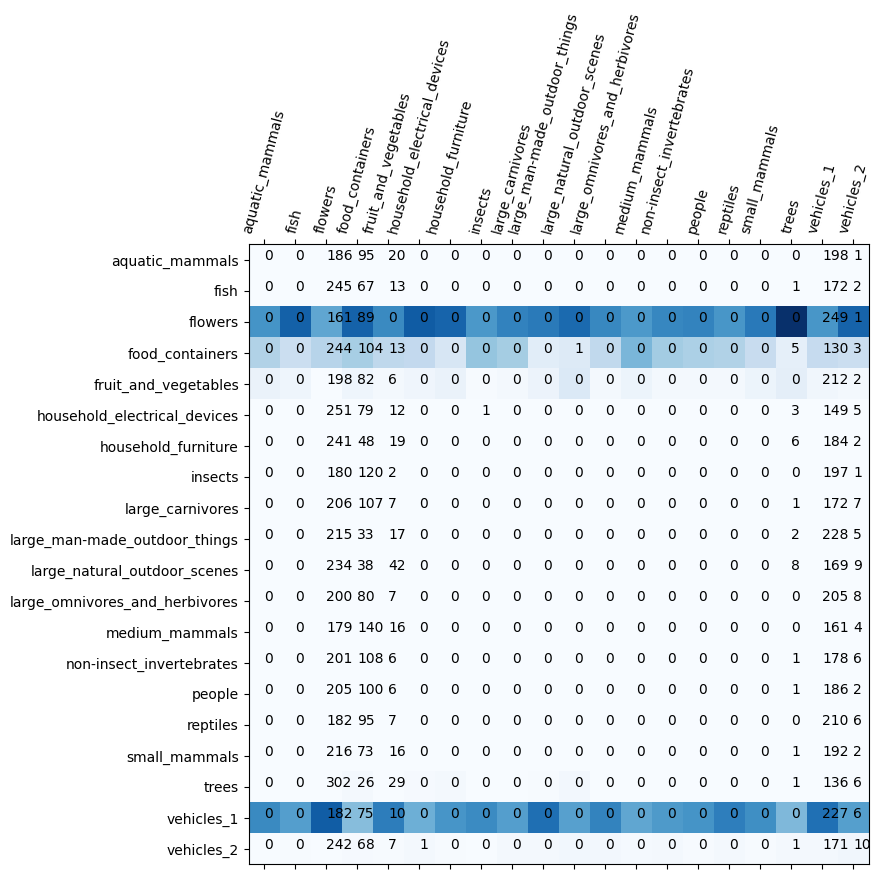

In [380]:
TP,FN = 0,0
cfm = np.zeros((20,20), dtype = np.int32)
for m in range(preds.shape[0]):  
    exp, pred = test_labels[m], preds[m]  
    if exp == pred: #True Positive
        cfm[exp][pred]+=1 
        TP+=1
    else: #False Positive
        cfm[pred][exp]+=1
        FN+=1 

#Accuracy
test_acc = (TP)/(TP+FN)
T = np.count_nonzero(preds==test_labels)
print('Total Test Labels : ',(TP+FN))
print('Total True predictions : ',TP)
print('Total False predictions : ',FN)
print('Testing accuracy : ',(test_acc*100))

#Confusion Matrix
print('\nConfusion Matrix Values are as follows : \n',np.matrix(cfm))

plt.matshow(cfm, cmap = 'Blues')
plt.xticks(np.arange(0, 20), label_names, rotation = 75)
plt.yticks(np.arange(0, 20), label_names)
#Plotting the matrix
for i  in range(20):
    for j in range(20):
        plt.text(x=i,y=j,s=cfm[i][j])
plt.show()

Following are the target classes : 
 ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']

Example of misclassified classes :
Expected Label: large_natural_outdoor_scenes
Predicted Label: aquatic_mammals


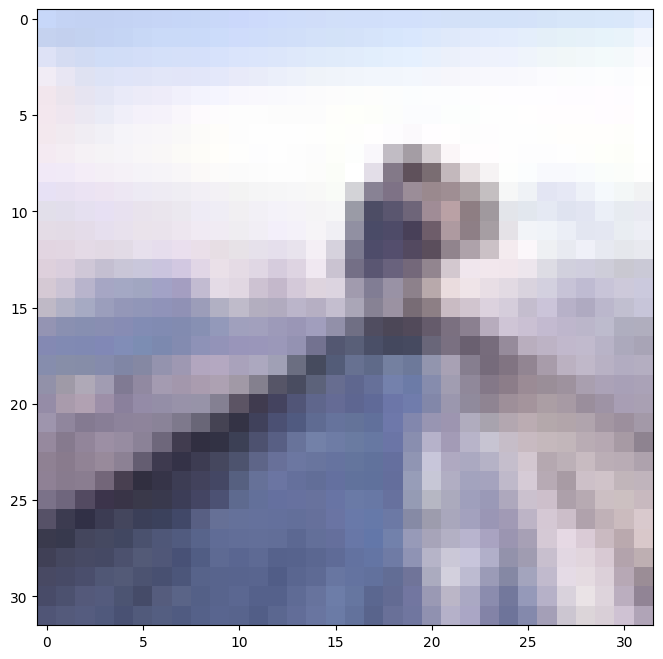

In [217]:
#Displaying Targeted classes
print('Following are the target classes : \n',label_names)


#Visualizing sample test data, image prediction and exectation
test_img_data = data['data_test'][0]
test_img_data = ((test_img_data*std_image + mean_image) * 255).astype(np.int32)

plt.imshow(test_img_data)

print('\nExample of misclassified classes :')
label = label_names[data['labels_test'][0]]
print("Expected Label:", label)

label = label_names[data['labels_test'][preds[0]]]
print("Predicted Label:", label)

In [ ]:
test_size = preds.shape[0]
T = np.count_nonzero(preds==test_labels)
F = test_size - T

print('Total Test Labels : ',test_size)
print('Total True predictions : ',T)
print('Total False predictions : ',F)
print('Testing accuracy ',(test_acc*100),'%')

conf_matrix = np.zeros((20,20,2,2))
small_test_labels = test_labels[0:1000]
small_pred_labels = preds[0:1000]

for i in range(20):
    for j in range(20):
        for exp in small_test_labels:
            for pred in small_pred_labels :
                if i == j : #Positive
                    if exp == pred: #True Positive
                        conf_matrix[i][j][0][0]+=1 
                    else: #False Positive
                        conf_matrix[i][j][1][0]+=1 
                else: #Negative
                    if exp != pred: #True Negative
                        conf_matrix[i][j][1][1]+=1 
                    else: #False Negative
                        conf_matrix[i][j][0][1]+=1 
    print('Label ',i,' processed...')

Total Test Labels :  10000
Total True predictions :  509
Total False predictions :  9491
Testing accuracy  5.09 %
Label  0  processed...
Label  1  processed...
Label  2  processed...
Label  3  processed...
Label  4  processed...
Label  5  processed...
Label  6  processed...
Label  7  processed...
Label  8  processed...
Label  9  processed...
Label  10  processed...
Label  11  processed...
Label  12  processed...
Label  13  processed...
Label  14  processed...
Label  15  processed...
Label  16  processed...
Label  17  processed...
Label  18  processed...
Label  19  processed...


Confusion Matrix : 
 [[[[ 49151.      0.]
   [950849.      0.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  ...

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]]


 [[[     0.  49151.]
   [     0. 950849.]]

  [[ 49151.      0.]
   [950849.      0.]]

  [[     0.  49151.]
   [     0. 950849.]]

  ...

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]]


 [[[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[ 49151.      0.]
   [950849.      0.]]

  ...

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]]


 ...


 [[[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  [[     0.  49151.]
   [     0. 950849.]]

  ...

  [[ 49151.   

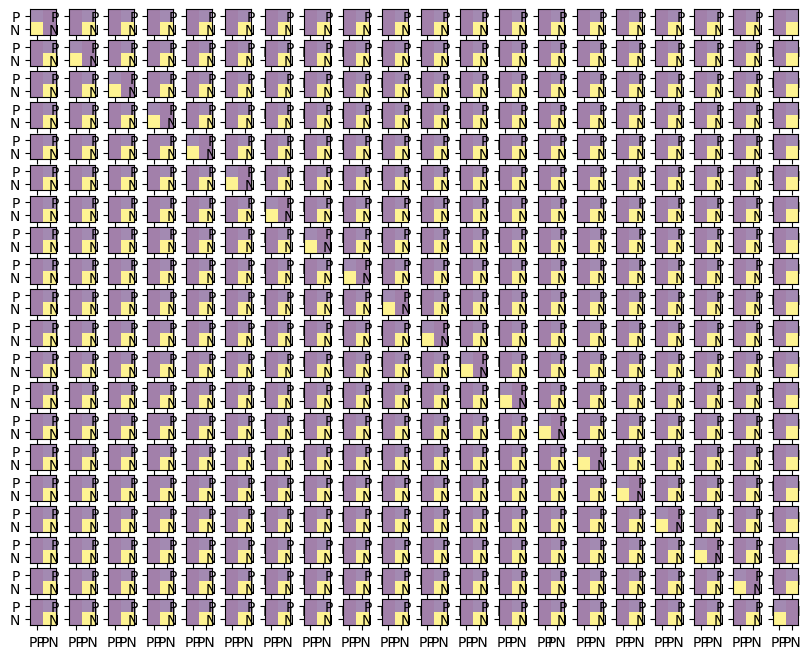

<Figure size 500x500 with 0 Axes>

In [323]:
print('Confusion Matrix : \n', conf_matrix)
#Displaying Targeted classes
print('\nFollowing are the target classes : \n',label_names)

fig, ax = plt.subplots(20,20)
plt.figure(figsize=(5,5))
for h in range(20):
    for w in range(20):
        ax[h,w].imshow(conf_matrix[h,w,:,:], cmap='viridis', alpha = 0.5)
        for i in range(conf_matrix.shape[2]):
            for j in range(conf_matrix.shape[3]):
                ax[h,w].set_xticks(np.arange(0, 2), ['PP','PN'])
                ax[h,w].set_yticks(np.arange(0, 2), ['P','N'])

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.